<a href="https://colab.research.google.com/github/BenYavor/MA_GAN/blob/master/MA_GAN_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.0.0-rc0
!pip install -q pyyaml h5py
#!pip install -q tf_nightly
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt   
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 
tf.__version__
from tensorflow import keras
import time

## System funktionsweise Allgemeine Daten

#### Rauschen
genarats-> **shape**: batch_size * number_of_real_channels_uses_per_message \\
and does a average power normalization


#### Generator
Eingang: (2*n,32)  ; Ausgang: (32,n)   \\
Loss-Function:

#### Discriminator
Eingang: (2*n,32)  ; Ausgang: (32,1)  \\
Loss-Function:


#### Training


###Systemparameter
$k$ - die Anzhal der bits \\
$M$ - Anzahl der unterschiedlichen Nachrichten \\
$n$ - channel uses **What is meant by that??** \\
$N$ - Länge des Rauschvektors

In [0]:
k = 4       # Number of information bits per message, i.e., M=2**k
M = 2**k
n = 2       # Number of real channel uses per message
seed = 2    # Seed RNG reproduce identical results
D_nb_weights = 32
G_nb_weights = 32


batch_size = 100


x = tf.random.normal((batch_size,n))    #randomly sample input data ("fake" AE messages)
x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x))) #Average power normalization (not required if standard normal distribution is used )

## Generator Model

In [85]:


#def generator(x):
    # Concatenate z and y
#    G_n = tf.random.normal([tf.shape(x)[0],n],dtype=tf.float32)  #create noise directly within the generator  
#    inputs = tf.concat(values=[x, G_n], axis=1)
    #dense NN
#    G_h1 = tf.nn.relu(tf.matmul(inputs, G_W1) + G_b1)
#    G_h2 = tf.nn.relu(tf.matmul(G_h1, G_W2) + G_b2)
#    G_lin = tf.matmul(G_h2, G_W3) + G_b3
    #G_prob = tf.nn.sigmoid(G_lin)
#    return G_lin

def generator_noise(input):
  G_n = tf.random.normal([tf.shape(input)[0],n],dtype=tf.float32)  #create noise directly within the generator  
  inputs = tf.concat(values=[input, G_n], axis=1)
  return inputs
    
def generator(x = tf.keras.Input(shape=(batch_size,n)),training = False):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Lambda(generator_noise))
  model.add(tf.keras.layers.Dense(32,use_bias=True, activation='relu'))#, input_shape=(2*n,))
  model.add(tf.keras.layers.Dense(32,use_bias=True,  activation='relu'))
  model.add(tf.keras.layers.Dense(n,use_bias=False, activation='sigmoid'))
  return model

generator= generator()
test = generator(x)
print(test[1])

tf.Tensor([0.4819897  0.49580827], shape=(2,), dtype=float32)


### Help Functions

In [0]:
def EbNo2Sigma(ebnodb):
    '''Convert Eb/No in dB to noise standard deviation'''
    ebno = 10**(ebnodb/10)
    return 1/np.sqrt(2*(2*k/n)*ebno)

#numpy version of kl divergence
def kl_divergence_np(p, q):
    #use "Laplace correction" w to avoid zero and inf
    w=1e-5
    p = p + w
    q = q + w
    return np.sum(p * np.log(p / q))

#tensorflow version of kl divergence
def kl_divergence_tf(p, q):
    #use "Laplace correction" w to avoid zero and inf
    w = 1e-5
    p = p + w
    q = q + w
    return tf.reduce_sum(p * tf.log(p / q))

## Channels as Black-Box

In [0]:
train_SNR_dB = 6
noise_std = EbNo2Sigma(train_SNR_dB)

def real_channel(x):
    # Black-box Channel
    #AWGN
    return x + tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std)

    #Rayleigh
    #return x + tf.sqrt(tf.square(tf.random_normal(tf.shape(x), mean=0.0, stddev=noise_std)) + tf.square(tf.random_normal(tf.shape(x), mean=0.0, stddev=noise_std)))
    
    #Uniform U(-3;3)    
    #return x + tf.random_uniform(tf.shape(x), minval=-2, maxval=2)

    


## Discriminator
Model definition and creating discriminator


In [0]:
def concc(y,x):  
  inputs = tf.concat(values=[y,x], axis=1)
  return inputs

def get_discriminator():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(32,use_bias=True, activation='relu',input_shape=((2*n,))))
  model.add(tf.keras.layers.Dense(16,use_bias=True,  activation='relu'))
  model.add(tf.keras.layers.Dense(1,use_bias=False,activation='sigmoid'))
  return model
discriminator = get_discriminator()

#def discriminator(y,x):
#    # Concatenate x and y
#    inputs = tf.concat(values=[y,x], axis=1)
#    #dense NN
#    D_h1 = tf.nn.relu(tf.matmul(inputs, D_W1) + D_b1)
#    D_logit = tf.matmul(D_h1, D_W2) + D_b2
#    D_prob = tf.nn.sigmoid(D_logit)
#    return D_prob, D_logit

## Data Generation, überhaupt noch relevant??!!

## discriminator desicion????


In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## Define Loss
strongly inspiered by: \\
https://www.tensorflow.org/beta/tutorials/generative/dcgan?hl=en

## defining Loss. TODO:
compile the Model with the right loss functions

In [90]:
x = tf.random.normal((batch_size,n),dtype=tf.dtypes.float32)    #randomly sample input data ("fake" AE messages)
x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x)))
real_training_data = tf.concat(values=[real_channel(x), x], axis=1)  
fake_training_data = tf.concat(values=[generator(x, training =True),x], axis=-1)

print(real_training_data.shape,fake_training_data.shape)
real_output = discriminator(real_training_data)
fake_output = discriminator(fake_training_data)
print(fake_output)
#print(real_output, fake_output)

(100, 4) (100, 4)
tf.Tensor(
[[0.54344714]
 [0.52413404]
 [0.5093189 ]
 [0.47057748]
 [0.49834082]
 [0.49357364]
 [0.47092938]
 [0.4735905 ]
 [0.5298665 ]
 [0.47384048]
 [0.5146605 ]
 [0.5057048 ]
 [0.4579929 ]
 [0.48269105]
 [0.46245638]
 [0.4708114 ]
 [0.4630347 ]
 [0.49307227]
 [0.48926246]
 [0.4943325 ]
 [0.4769314 ]
 [0.46299317]
 [0.506287  ]
 [0.57897127]
 [0.47680417]
 [0.45935446]
 [0.5330456 ]
 [0.4870076 ]
 [0.5180583 ]
 [0.46314695]
 [0.5981809 ]
 [0.50010836]
 [0.47111678]
 [0.4682378 ]
 [0.4780353 ]
 [0.48626384]
 [0.5098014 ]
 [0.46961588]
 [0.5168476 ]
 [0.44376442]
 [0.5450507 ]
 [0.4548832 ]
 [0.4559648 ]
 [0.5274183 ]
 [0.46578768]
 [0.49688193]
 [0.5207453 ]
 [0.6131379 ]
 [0.46158704]
 [0.5192825 ]
 [0.4781421 ]
 [0.4847735 ]
 [0.46610832]
 [0.44834983]
 [0.4232902 ]
 [0.51398677]
 [0.49661645]
 [0.55749094]
 [0.45519724]
 [0.52903694]
 [0.47296402]
 [0.4412995 ]
 [0.54145473]
 [0.53865755]
 [0.5749943 ]
 [0.5255321 ]
 [0.5322074 ]
 [0.46515125]
 [0.567675  ]
 [0.4

In [0]:
def discriminator_loss(real_output, fake_output):
  loss= -tf.reduce_mean(tf.math.log(real_output) + tf.math.log(1. - fake_output))   #use "-" sign to minimize rather than maximize loss
  return loss
  
def generator_loss(fake_output, generator):
  loss = -tf.reduce_mean(tf.math.log(fake_output))
  return loss

generator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
discriminator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

# Evaluation with Histogram

In [0]:
def generate_evaluation_data(batch_size=100):
  x = tf.random.normal((batch_size,n),dtype=tf.dtypes.float32)    #randomly sample input data ("fake" AE messages)
  x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x))) #Average power normalization (not required if standard normal distribution is used )
  #G_n = tf.random.normal([tf.shape(x)[0],n],dtype=tf.float32) 
  #inputs = tf.concat(values=[x, G_n], axis=1)
  fake_eval_data = tf.concat(values=[generator(x), x], axis=1)
  real_eval_data = tf.concat(values=[real_channel(x), x], axis=1) #tf.concat(values=[real_channel(x),x], axis=1)
  inputs = x
  return  real_eval_data, fake_eval_data, inputs 



def get_evaluation_data(evaluation_per_epochs):
  real_eval_data = []
  fake_eval_data  = []
  inputs = []
  for i in range(evaluation_per_epochs):
    data = generate_evaluation_data()
    real_eval_data.append(data[0])
    fake_eval_data.append(data[1])
    inputs.append(data[2])
  return real_eval_data, fake_eval_data, inputs


def test_eval(real_eval_data,fake_eval_data,inputs):
  hist_range = 2
  
  inputs_ = tf.concat(values=[inputs, inputs],  axis=-1)
  
  fake_output_hist = np.mean(fake_eval_data,axis=1)  # Changed from 0 to 1
  real_output_hist = np.mean(real_eval_data,axis=1)
  inputs_hist = np.mean(inputs_,axis=1)
    
  fake_output_hist1 = np.reshape( fake_output_hist,[-1,])
  real_output_hist1 = np.reshape( real_output_hist,[-1,])
    
  plt.hist(fake_output_hist1,bins=100,range=(-hist_range,hist_range),density=True,histtype='step')
  plt.hist(real_output_hist1,bins=100,range=(-hist_range,hist_range),density=True,histtype='step')    
  plt.title("noise distribution")
  plt.legend(["generator", "target"])
  plt.show()
  
  fake_noise = np.reshape( fake_output_hist - inputs_hist,[-1,])
  real_noise = np.reshape( real_output_hist - inputs_hist,[-1,])
   
  plt.hist(fake_noise,bins=100,range=(-hist_range,hist_range),density=True,histtype='step')
  plt.hist(real_noise,bins=100,range=(-hist_range,hist_range),density=True,histtype='step')    
  plt.title("noise distribution after subtracting Inpus_noise")
  plt.legend(["generator", "target"])
  plt.show()
    
    #print("decision for fake data was %d: and for real data was %d:" % (decision_fake, decision_real))

### Define the training loop

In [0]:
epochs = 25
steps_per_epoches = 50
batch_size = 100

evaluation_per_epochs = 100

noise_dim = n        #noch ändern wenn ich noise ändere
num_examples_to_generate = 16




In [0]:
def train(epochs, steps_per_epoches , batch_size, generator, discriminator):
  start = time.time()
  counter = 0
  epoch = 0
  for epoch in range(epochs):
    start = time.time()
    #print(massege_batch)
    counter += 1
    train_step(epoch, steps_per_epoches , batch_size, generator, discriminator) 
    if counter%5 == 0:
      print("counter %d:" % (counter))
    if counter%5 == 0:
      real_eval_data, fake_eval_data, inputs = get_evaluation_data(evaluation_per_epochs)
      test_eval(real_eval_data, fake_eval_data, inputs)
    print ('Time for epoch {} is {} sec,'.format(epoch + 1, time.time()-start))
    x = tf.random.normal((batch_size,n),dtype=tf.dtypes.float32)    #randomly sample input data ("fake" AE messages)
    x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x)))
    #print(x)
    real_c = real_channel(x)
    fake_c = generator(x)
    if tf.math.is_nan(fake_c[1,1]) == True:
      print("doesn't train the generator as expacted")
      tf.debugging.check_numerics(fake_c,'message',name=None)
      break # in order to finde wher the [nan] - prolem is cumming from
    
       
  #checkpoint_path = "training_1/cp.ckpt"
  #checkpoint_dir = os.path.dirname(checkpoint_path)

  #cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
  #                                               save_weights_only=False,
  #                                               verbose=1)    
  tf.saved_model.save(generator,'/tmp/saved_model/')
  print ('Time for the training is {} sec,'.format( time.time()-start))
  print(gradients_of_generator)  
  

  # Generate after the final epoch
    


The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [0]:
#@tf.function
#def train_step(massege_batch,counter):
#    x = tf.random.normal((batch_size,n),dtype=tf.dtypes.float32)    #randomly sample input data ("fake" AE messages)
#    x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x)))
    #G_n = tf.random.normal([tf.shape(x)[0],n],dtype=tf.float32) 
    #inputs = tf.concat(values=[x, G_n], axis=1)
#    real_training_data = tf.concat(values=[real_channel(x), x], axis=1)  #tf.concat(values=[real_channel(x),x], axis=1)


 #   with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:           #tapes the gradient of the generaor an the discriminator
  #    fake_training_data = tf.concat(values=[generator(x, training =True),x], axis=1)
      
 #     real_output = discriminator(real_training_data, training=True)
 #     fake_output = discriminator(fake_training_data, training=True)

 #     disc_loss = -tf.reduce_mean(tf.math.log(real_output) + tf.math.log(1. - fake_output))   #use "-" sign to minimize rather than maximize loss
 #     gen_loss = -tf.reduce_mean(tf.math.log(fake_output))

 #     gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
 #     gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  #    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  #    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    


In [0]:
@tf.function

def train_step(epoch, steps_per_epoches , batch_size, generator, discriminator):

    
  for j in range(steps_per_epoches):
    x = tf.random.normal((batch_size,n),dtype=tf.dtypes.float32)    #randomly sample input data ("fake" AE messages)
    x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x)))
    real_training_data = tf.concat(values=[real_channel(x), x], axis=1)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      fake_training_data = tf.concat(values=[generator(x, training =True),x], axis=1)
      real_output = discriminator(real_training_data, training=True)
      fake_output = discriminator(fake_training_data, training=True)
      disc_loss = -tf.reduce_mean(tf.math.log(real_output) + tf.math.log(1. - fake_output))   #use "-" sign to minimize rather than maximize loss
      gen_loss = -tf.reduce_mean(tf.math.log(fake_output))
      #print(disc_loss, gen_loss)
          
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
      
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    



## Train the model

Tensor("Neg:0", shape=(), dtype=float32) Tensor("Neg_1:0", shape=(), dtype=float32)
Tensor("Neg_5:0", shape=(), dtype=float32) Tensor("Neg_6:0", shape=(), dtype=float32)
Tensor("Neg_10:0", shape=(), dtype=float32) Tensor("Neg_11:0", shape=(), dtype=float32)
Tensor("Neg_15:0", shape=(), dtype=float32) Tensor("Neg_16:0", shape=(), dtype=float32)
Tensor("Neg_20:0", shape=(), dtype=float32) Tensor("Neg_21:0", shape=(), dtype=float32)
Tensor("Neg_25:0", shape=(), dtype=float32) Tensor("Neg_26:0", shape=(), dtype=float32)
Tensor("Neg_30:0", shape=(), dtype=float32) Tensor("Neg_31:0", shape=(), dtype=float32)
Tensor("Neg_35:0", shape=(), dtype=float32) Tensor("Neg_36:0", shape=(), dtype=float32)
Tensor("Neg_40:0", shape=(), dtype=float32) Tensor("Neg_41:0", shape=(), dtype=float32)
Tensor("Neg_45:0", shape=(), dtype=float32) Tensor("Neg_46:0", shape=(), dtype=float32)
Tensor("Neg_50:0", shape=(), dtype=float32) Tensor("Neg_51:0", shape=(), dtype=float32)
Tensor("Neg_55:0", shape=(), dtype=flo

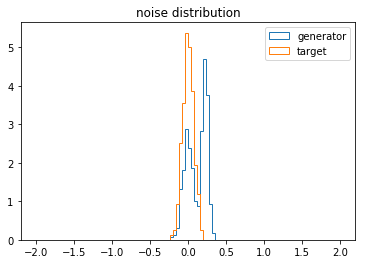

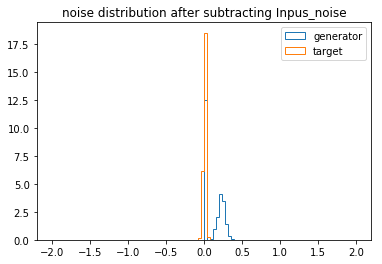

Time for epoch 5 is 34.23688817024231 sec,
Tensor("Neg:0", shape=(), dtype=float32) Tensor("Neg_1:0", shape=(), dtype=float32)
Tensor("Neg_5:0", shape=(), dtype=float32) Tensor("Neg_6:0", shape=(), dtype=float32)
Tensor("Neg_10:0", shape=(), dtype=float32) Tensor("Neg_11:0", shape=(), dtype=float32)
Tensor("Neg_15:0", shape=(), dtype=float32) Tensor("Neg_16:0", shape=(), dtype=float32)
Tensor("Neg_20:0", shape=(), dtype=float32) Tensor("Neg_21:0", shape=(), dtype=float32)
Tensor("Neg_25:0", shape=(), dtype=float32) Tensor("Neg_26:0", shape=(), dtype=float32)
Tensor("Neg_30:0", shape=(), dtype=float32) Tensor("Neg_31:0", shape=(), dtype=float32)
Tensor("Neg_35:0", shape=(), dtype=float32) Tensor("Neg_36:0", shape=(), dtype=float32)
Tensor("Neg_40:0", shape=(), dtype=float32) Tensor("Neg_41:0", shape=(), dtype=float32)
Tensor("Neg_45:0", shape=(), dtype=float32) Tensor("Neg_46:0", shape=(), dtype=float32)
Tensor("Neg_50:0", shape=(), dtype=float32) Tensor("Neg_51:0", shape=(), dtype=floa

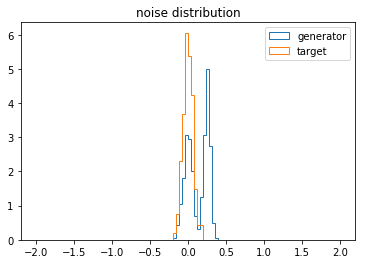

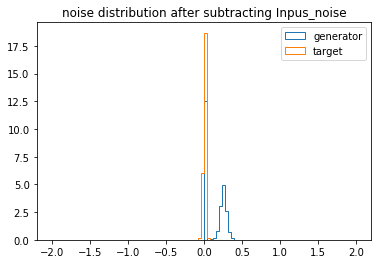

Time for epoch 10 is 37.389392614364624 sec,
Tensor("Neg:0", shape=(), dtype=float32) Tensor("Neg_1:0", shape=(), dtype=float32)
Tensor("Neg_5:0", shape=(), dtype=float32) Tensor("Neg_6:0", shape=(), dtype=float32)
Tensor("Neg_10:0", shape=(), dtype=float32) Tensor("Neg_11:0", shape=(), dtype=float32)
Tensor("Neg_15:0", shape=(), dtype=float32) Tensor("Neg_16:0", shape=(), dtype=float32)
Tensor("Neg_20:0", shape=(), dtype=float32) Tensor("Neg_21:0", shape=(), dtype=float32)
Tensor("Neg_25:0", shape=(), dtype=float32) Tensor("Neg_26:0", shape=(), dtype=float32)
Tensor("Neg_30:0", shape=(), dtype=float32) Tensor("Neg_31:0", shape=(), dtype=float32)
Tensor("Neg_35:0", shape=(), dtype=float32) Tensor("Neg_36:0", shape=(), dtype=float32)
Tensor("Neg_40:0", shape=(), dtype=float32) Tensor("Neg_41:0", shape=(), dtype=float32)
Tensor("Neg_45:0", shape=(), dtype=float32) Tensor("Neg_46:0", shape=(), dtype=float32)
Tensor("Neg_50:0", shape=(), dtype=float32) Tensor("Neg_51:0", shape=(), dtype=fl

KeyboardInterrupt: ignored

In [96]:
%%time
train(epochs, steps_per_epoches , batch_size, generator, discriminator)

generator.summary()
discriminator.summary()

### Restore the latest checkpoint.

In [0]:
x = tf.random.normal((batch_size,n),dtype=tf.dtypes.float32)    #randomly sample input data ("fake" AE messages)
x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x)))
#print(x)
real_c = real_channel(x)
fake_c = generator(x)

tf.debugging.check_numerics(fake_c,'message',name=None)

## AE
Die Idee sollte sein das Training auf den encoder und decoder einzuschränken. Jedoch soll **end-to-end** trainiert werden, hierfür sollte vllt eine art Funktion eingesetzt werden, welche über die GAN's Layer zurück geht.
Muss ich hierfür die Layer nochmals einzeln definieren?


***Vermutung: Der Ausgang hat die 8fache dimension des Eingangs-> daher nur 1/8 richtig oder 7/8 richtig*** \\
**zu klären: was passiert in meinem AE dass sie dei dimension ver8-facht von (1000,8) zu (8000,n)**
**Kontrollieren was der output von meinem GAN ist**
**Add complexity for higher rubustness**




In [0]:


def get_encoder():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.InputLayer(input_shape=[M]))
  model.add(tf.keras.layers.Dense(M,use_bias=True, activation='relu'))
  model.add(tf.keras.layers.Dense(M,use_bias=True, activation='relu'))
  model.add(tf.keras.layers.Dense(n,use_bias=False, activation=None))
  model.add(tf.keras.layers.Lambda(lambda x : tf.divide(x, tf.sqrt(2*tf.reduce_mean(tf.square(x))))))
  return model

def get_decoder():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.InputLayer(input_shape=[n]))
  model.add(tf.keras.layers.Dense(n,use_bias=True, activation='relu'))
  model.add(tf.keras.layers.Dense(M,use_bias=True, activation='relu'))
  model.add(tf.keras.layers.Dense(M,use_bias=False, activation='softmax'))
  return model

encoder = get_encoder()
decoder = get_decoder()

encoder.summary()
generator.summary()
decoder.summary()
   
def get_AE(encoder, generator, decoder):
  AE_model = tf.keras.Sequential()
  AE_model.add(encoder)
  AE_model.add(tf.keras.layers.Lambda(generator))
  AE_model.add(decoder)
  return AE_model
          
    
def generate_data_vector(length):
  random_vector = tf.random.uniform(shape =(length,),minval=0,maxval=M, dtype=tf.dtypes.int32 ,seed=None,name=None)
  random_hot_one_vector = tf.one_hot(random_vector, depth=M,on_value=1, off_value=0,axis=-1)
  print(random_hot_one_vector.shape)
  return random_hot_one_vector

data, test_data = generate_data_vector(1000000), generate_data_vector(10000)
#print(data)

#model = Autoencoder()
AE = get_AE(encoder, generator, decoder)
AE.compile(optimizer='nadam',loss='categorical_crossentropy',metrics=['accuracy'])
history = AE.fit(data, data, batch_size=100,steps_per_epoch=3000, epochs=5)





  

In [0]:
train_SNR_dB = 6

def analytic_channel(input): 
  #print(input.shape)
  return input + tf.random.normal(tf.shape(input), mean=0.0, stddev=noise_std)

def real_transmision(test_data):
  y = encoder(test_data)
  y = generator(y)
  y = decoder(y)
  return y
  #model = tf.keras.Sequential()
  #model.add(encoder)
  #model.add(tf.keras.layers.Lambda(generator))
  #model.add(tf.keras.layers.Lambda(real_channel))
  #model.add(decoder)
  #return model

def test_diff_eval(test_data, results):
  diff = []
  for i in range(tf.shape(test_data)[0]):
    diff.append(tf.math.subtract(test_data[i,:], results[i,:]))
  return diff
    
  
real_AE = real_transmision(test_data)
testTest = tf.dtypes.cast(real_AE + tf.constant(0.1,dtype=tf.float32,shape=tf.shape(real_AE)), tf.int32)

diff_test =  test_diff_eval(test_data, testTest) 
#t = tf.math.subtract(test_data[1,:], real_AE[1,:])





In [0]:
print(sum(diff_test))

In [0]:
tes_data = np.eye(M, dtype = int)
coding= encoder.predict(tes_data)
fig = plt.figure(figsize=(4,4))
plt.plot(coding[:,0], coding[:,1],"b.")
plt.gca().set_ylim(-2,2)
plt.gca().set_xlim(-2,2)
plt.show()

## Trainingparameters

In [0]:
train_EbNodB = 6
val_EbNodB = train_EbNodB

training_params = [
    #batch_size, lr, ebnodb, iterations
    [100    , 0.001, train_EbNodB, 1000],
    [100    , 0.0001, train_EbNodB, 10000],
    [1000    , 0.0001, train_EbNodB, 10000]
]

validation_params = [
    #batch_size, ebnodb, val_steps 
    [100000, val_EbNodB, 100],
    [100000, val_EbNodB, 1000],
    [100000, val_EbNodB, 1000]
]

## Create and train model

In [0]:
model_file_baseline = 'models/ae_baseline_k_{}_n_{}'.format(k,n)

ae_baseline = AE(k,n,useGAN=False,seed=seed)
ae_baseline.train(training_params, validation_params)

ae_baseline.save(model_file_baseline)